In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
from torch.autograd import Variable
import cv2
import numpy as np

Encode the reference logo image through ResNet


In [ ]:
def encode_logo(logo_path):

      # Pretrained model

      model = models.resnet18(pretrained=True)

      # Select specific layer

      layer = model._modules.get('avgpool')

      # Set model to evaluation mode

      model.eval()

      transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

      logo = Image.open(logo_path)

      # PyTorch variable for the transformed image

      transformed_logo = transform(logo).unsqueeze(0)
      transformed_img = Variable(transformed_logo)

      embedding = torch.zeros(512) #    The 'avgpool' layer has an output size of 512

      # Function that copies output of a layer

      def copy_data(m, i, o):
          embedding.copy_(o.squeeze().data)

      # Attach that function to our selected layer
      h = layer.register_forward_hook(copy_data)

      # Run model on transformed img
      model(transformed_img)

      # Detach function from layer
      h.remove()

      # Return feature embedding
      return embedding.numpy()

Encode the cropped logos detected with Yolo stored in yolo_results_crops and perform cosine similiarity with the encoded reference logo for each of them. Display results.


In [ ]:
import os
import matplotlib.pyplot as plt
import cv2


def compute_matches(detected_logo_folder, reference_feat, visualize = True):

  similiarities = []

  filenames = os.listdir(detected_logo_folder)

  # Sort the filenames alphabetically
  sorted_filenames = sorted(filenames)


  # Iterate through the detected logo crops
  for filename in sorted_filenames:

    if filename.endswith('.jpg') and not filename.startswith('detected'):  # Assuming the images have a .jpg extension

      detected_logo_path = os.path.join(detected_logo_folder, filename)

      detected_features = encode_logo(detected_logo_path)

      # Calculate cosine similarity with the reference logo features
      similiarity =  np.dot(reference_feat, detected_features) / (np.linalg.norm(reference_feat) * np.linalg.norm(detected_features))

      similiarities.append(similiarity)

      if (visualize):
        img = cv2.imread(detected_logo_path)
        img = img[...,::-1]

        # Create a figure and axis
        fig, ax = plt.subplots()

        # Display the image
        ax.imshow(img)

        ax.text(img.shape[1], img.shape[0] / 2, f"Similarity with reference logo: {similiarity.item()}", fontsize=12, color='red')

        # Remove the axis labels and ticks
        ax.axis('off')

        # Show the image with text
        plt.show()

  return similiarities

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


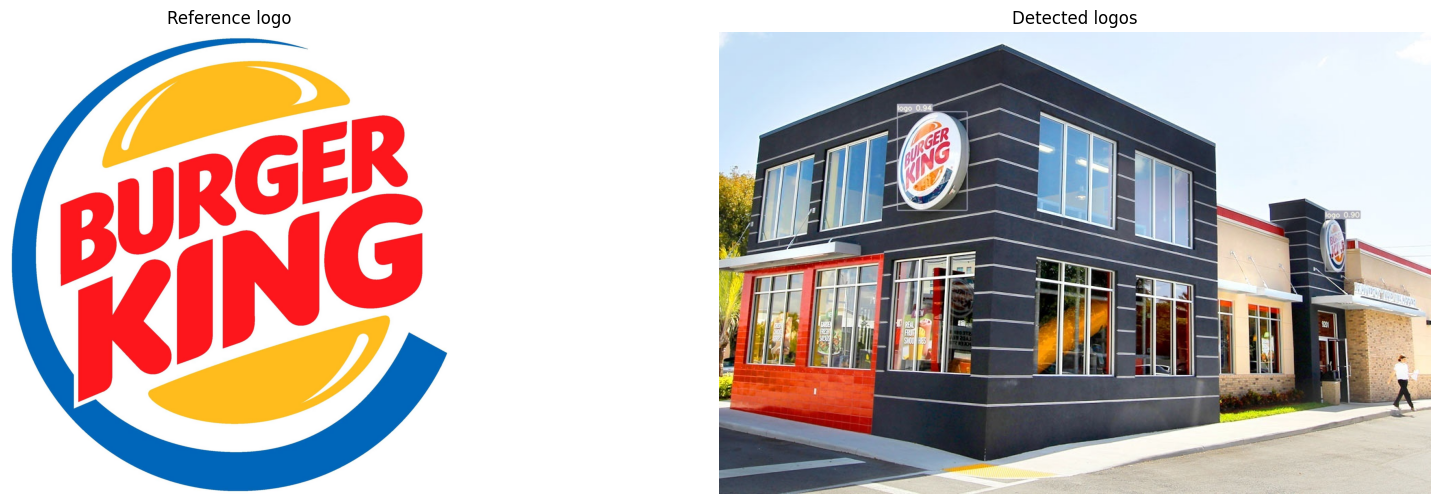

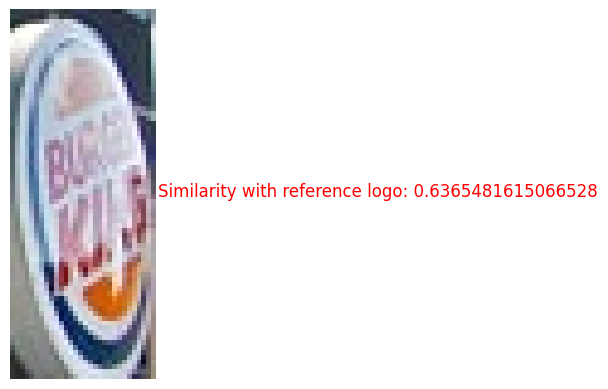

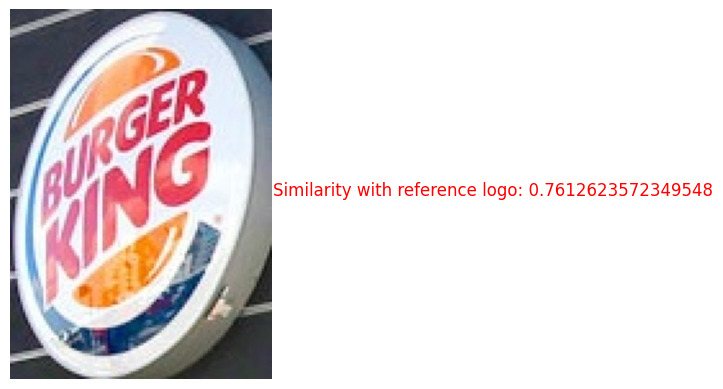

[0.63654816, 0.76126236]

In [ ]:
reference_logo_path = '/content/drive/MyDrive/VISION/ref_logos/burgerking.jpg'

detected_logo_folder = '/content/drive/MyDrive/VISION/yolo_results_crops/'

fig, ax = plt.subplots(1, 2, figsize=(20, 6), width_ratios=[1, 2])

ax[0].imshow(cv2.imread(reference_logo_path)[...,::-1])
ax[0].set_title('Reference logo')
ax[0].axis('off')
ax[1].imshow(cv2.imread('/content/drive/MyDrive/VISION/yolo_results_crops/detected.jpg')[...,::-1])
ax[1].set_title('Detected logos')
ax[1].axis('off')

reference_feat = encode_logo(reference_logo_path)

compute_matches(detected_logo_folder, reference_feat)


# Test against different logos

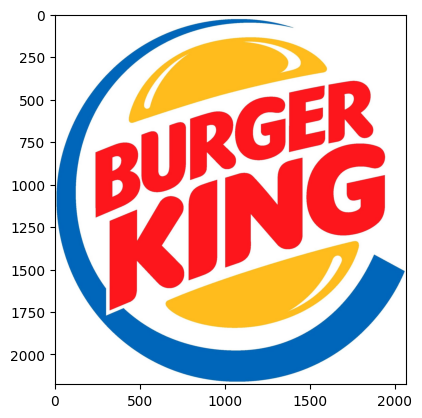

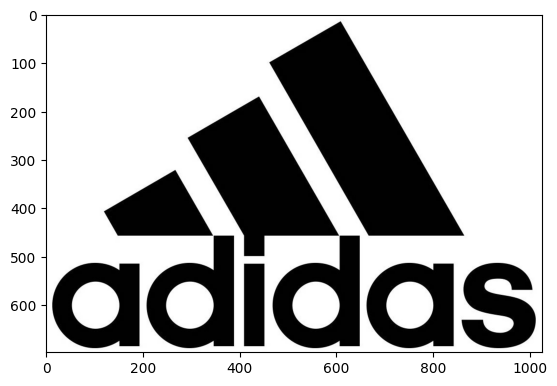

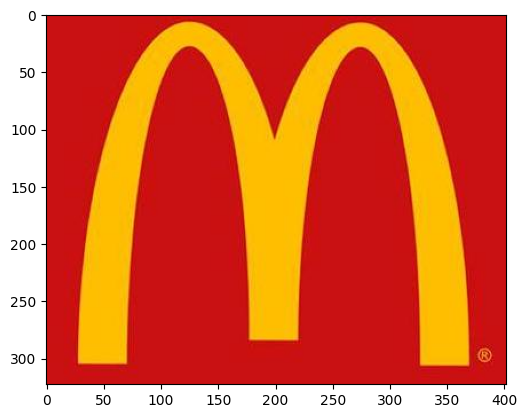

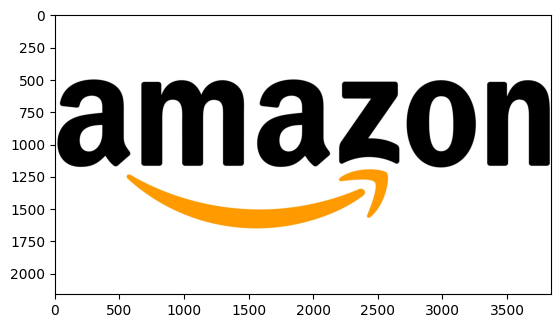

In [ ]:
ref_paths = ['burgerking.jpg','adidas.jpg','mc.jpg', 'amazon.jpg']
ref_logos_paths = [ os.path.join('/content/drive/MyDrive/VISION/ref_logos', path) for path in ref_paths]

for img_path in ref_logos_paths:
    img = cv2.imread(img_path)[...,::-1]
    plt.imshow(img)
    plt.show()

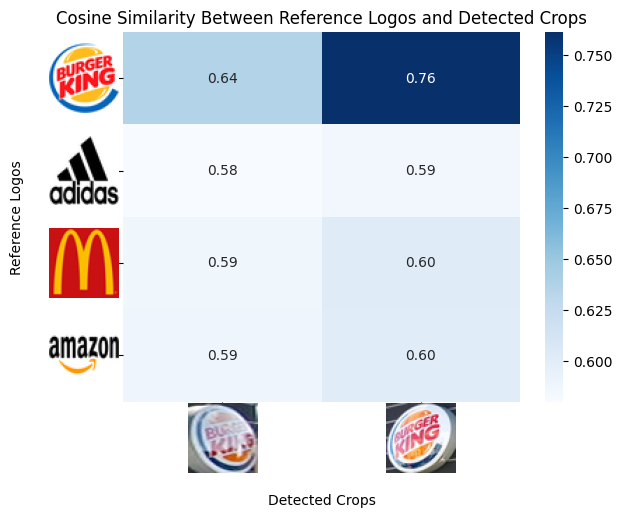

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

logos_detected = os.listdir(detected_logo_folder)
sorted_logos_detected = sorted(logos_detected)
logos_detected_files=[]


for file in (sorted_logos_detected):
  if file.endswith(".jpg") and not file.startswith("detected"):
    logos_detected_files.append(file)

logos_detected_paths =  [ os.path.join('/content/drive/MyDrive/VISION/yolo_results_crops', path) for path in logos_detected_files]

similiarity_matrix = []

for i in range(len(ref_logos_paths)):
  ref_features = encode_logo(ref_logos_paths[i])
  similiarities = compute_matches(detected_logo_folder, ref_features, False)
  similiarity_matrix.append(similiarities)
  #for j in range(len(similiarities)):
      #print(f"Reference {ref_logos_paths[i]} vs. Crop {j}: Similarity = {similiarities[j]}")

matrix = np.array(similiarity_matrix)

# Create a heatmap of the similarity matrix
ax = sns.heatmap(matrix, annot=True, fmt='.2f', cmap='Blues')

plt.xlabel('Detected Crops')
plt.ylabel('Reference Logos')
ax.yaxis.set_label_coords(-0.25, 0.5)
ax.xaxis.set_label_coords(0.5, -0.25)
plt.title('Cosine Similarity Between Reference Logos and Detected Crops')


plt.xticks(np.arange(len(matrix[0])) + 0.5, [f'Crop {i+1}' for i in range(len(matrix[0]))]
)

y_labels = ref_logos_paths
y_tick_positions = np.arange(len(y_labels)) + 0.5
ax.set_yticks(y_tick_positions)

x_labels = logos_detected_paths
x_tick_positions = np.arange(len(x_labels)) + 0.5
ax.set_xticks(x_tick_positions)

# Function to load, resize, and add images as tick labels
def add_image_tick_labels(ax, tick_positions, image_paths, axis='x', image_size=(50, 50)):
    for i, position in enumerate(tick_positions):
        image_path = image_paths[i]
        img = Image.open(image_path)
        img = img.resize(image_size, Image.Resampling.LANCZOS)  # Resize the image
        img = np.array(img)  # Convert to NumPy array
        if axis == 'x':
            imagebox = OffsetImage(img, zoom=1)
            ab = AnnotationBbox(imagebox, (position, -0.1), frameon=False, pad=0.0, xycoords=('data', 'axes fraction'))
        elif axis == 'y':
            imagebox = OffsetImage(img, zoom=1)
            ab = AnnotationBbox(imagebox, (-0.1, position), frameon=False, pad=0.0, xycoords=('axes fraction', 'data'))
        ax.add_artist(ab)

add_image_tick_labels(ax, y_tick_positions, y_labels, axis='y')

add_image_tick_labels(ax, x_tick_positions, x_labels, axis='x')

plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 44.5MB/s]


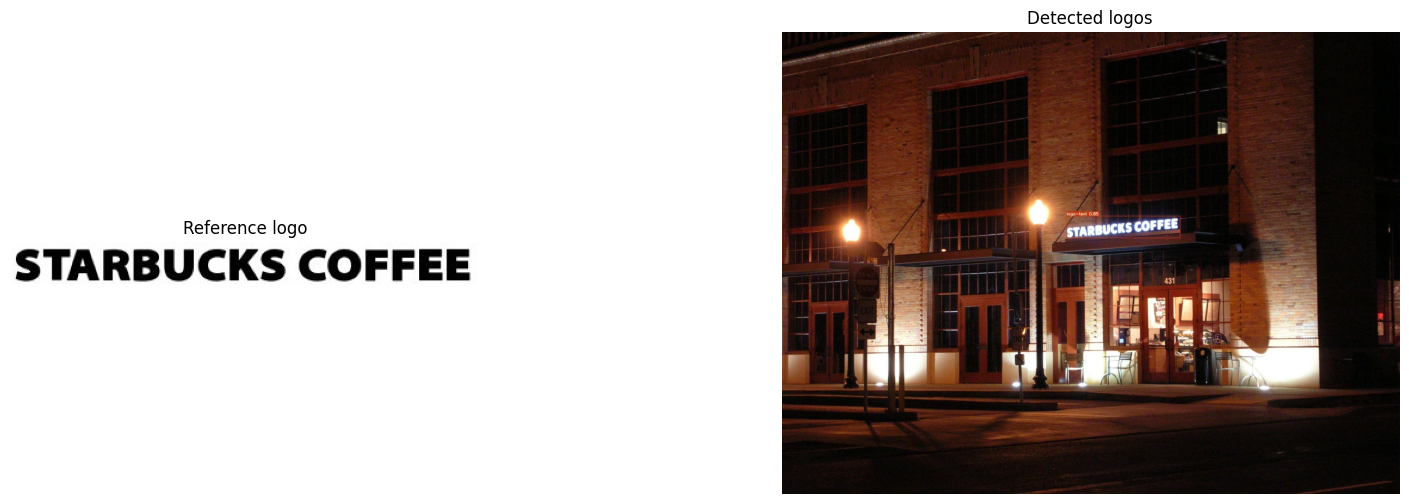

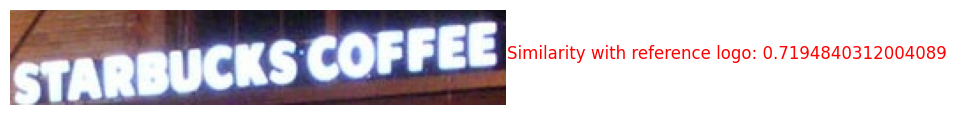

[0.71948403]

In [ ]:
reference_logo_path = '/content/drive/MyDrive/VISION/ref_logos/starbucks-text.jpg'

detected_logo_folder = '/content/drive/MyDrive/VISION/yolo_results_crops/'

fig, ax = plt.subplots(1, 2, figsize=(20, 6), width_ratios=[1, 2])

ax[0].imshow(cv2.imread(reference_logo_path)[...,::-1])
ax[0].set_title('Reference logo')
ax[0].axis('off')
ax[1].imshow(cv2.imread('/content/drive/MyDrive/VISION/yolo_results_crops/detected.jpg')[...,::-1])
ax[1].set_title('Detected logos')
ax[1].axis('off')

reference_feat = encode_logo(reference_logo_path)

compute_matches(detected_logo_folder, reference_feat)


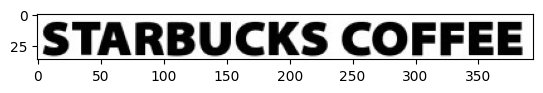

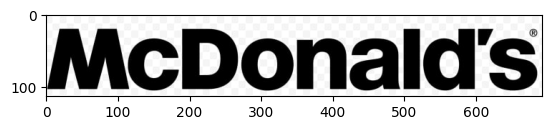

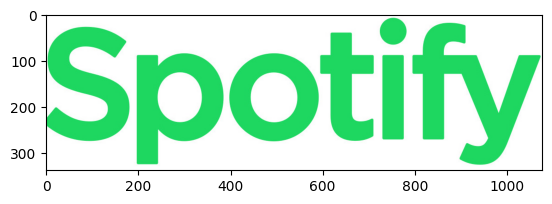

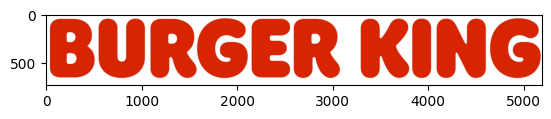

In [ ]:
ref_paths_text = ['starbucks-text.jpg','mc-text.jpg','spotify-text.jpg', 'burgerking-text.jpg']
ref_logos_paths_text = [ os.path.join('/content/drive/MyDrive/VISION/ref_logos', path) for path in ref_paths_text]

for img_path in ref_logos_paths_text:
    img = cv2.imread(img_path)[...,::-1]
    plt.imshow(img)
    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


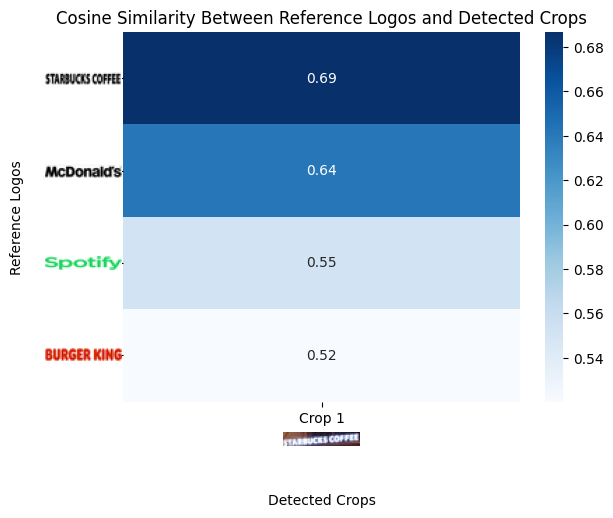

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

logos_detected = os.listdir(detected_logo_folder)
sorted_logos_detected = sorted(logos_detected)
logos_detected_files=[]


for file in (sorted_logos_detected):
  if file.endswith(".jpg") and not file.startswith("detected"):
    logos_detected_files.append(file)

logos_detected_paths =  [ os.path.join('/content/drive/MyDrive/VISION/yolo_results_crops', path) for path in logos_detected_files]

similiarity_matrix_text = []

for i in range(len(ref_logos_paths_text)):
  ref_features = encode_logo(ref_logos_paths_text[i])
  similiarities = compute_matches(detected_logo_folder, ref_features, False)
  similiarity_matrix_text.append(similiarities)
  #for j in range(len(similiarities)):
      #print(f"Reference {ref_logos_paths[i]} vs. Crop {j}: Similarity = {similiarities[j]}")

matrix_text = np.array(similiarity_matrix_text)

# Create a heatmap of the similarity matrix
ax = sns.heatmap(matrix_text, annot=True, fmt='.2f', cmap='Blues')

plt.xlabel('Detected Crops')
plt.ylabel('Reference Logos')
ax.yaxis.set_label_coords(-0.25, 0.5)
ax.xaxis.set_label_coords(0.5, -0.25)
plt.title('Cosine Similarity Between Reference Logos and Detected Crops')


plt.xticks(np.arange(len(matrix_text[0])) + 0.5, [f'Crop {i+1}' for i in range(len(matrix_text[0]))])

y_labels = ref_logos_paths_text
y_tick_positions = np.arange(len(y_labels)) + 0.5
ax.set_yticks(y_tick_positions)

x_labels = logos_detected_paths
x_tick_positions = np.arange(len(x_labels)) + 0.5
ax.set_xticks(x_tick_positions)

# Function to load, resize, and add images as tick labels
def add_image_tick_labels(ax, tick_positions, image_paths, axis='x', image_size=(55, 10)):
    for i, position in enumerate(tick_positions):
        image_path = image_paths[i]
        img = Image.open(image_path)
        img = img.resize(image_size, Image.Resampling.LANCZOS)  # Resize the image
        img = np.array(img)  # Convert to NumPy array
        if axis == 'x':
            imagebox = OffsetImage(img, zoom=1)
            ab = AnnotationBbox(imagebox, (position, -0.1), frameon=False, pad=0.0, xycoords=('data', 'axes fraction'))
        elif axis == 'y':
            imagebox = OffsetImage(img, zoom=1)
            ab = AnnotationBbox(imagebox, (-0.1, position), frameon=False, pad=0.0, xycoords=('axes fraction', 'data'))
        ax.add_artist(ab)

add_image_tick_labels(ax, y_tick_positions, y_labels, axis='y')

add_image_tick_labels(ax, x_tick_positions, x_labels, axis='x')

plt.show()